In [22]:
# This file serves to compare real school data to simulated data
# INPUT:
#     g matrix of connections between individuals
#     X matrix of characteristics of the individuals
# OUTPUT:
#     segregation plots
#     outdegree plot
#     outdegree correlations plot
#     local clustering coefficient plot

In [19]:
import pickle
import numpy as np
import copy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

In [3]:
# Import the data from pickle files
g_list = pickle.load(open("g_list.pkl", "rb"))
X_list = pickle.load(open("X_list.pkl", "rb"))
g_simulations = pickle.load(open("simulated_friendships.pkl", "rb"))

In [13]:
# make a list of schools observed and the simulations
# this results in the list datasets, which contains all information to be analysed
# the format of each separate dataset is a list: [g matrix, X matrix]

n_0_399 = [0, 1, 3, 4, 6, 7, 16, 19, 52, 60, 67, 68, 69, 73, 74] # excluded number 2 as it contains 2 schools
# also remove 2 from the simulations
del g_simulations[2]

schools_0_399 = []
for n in n_0_399:
    schools_0_399.append([g_list[n],X_list[n]])
simulations = []
for pos,n in enumerate(n_0_399):
    simulations.append([g_simulations[pos],X_list[n]])
datasets = [schools_0_399,simulations]

16
15


In [15]:
# check for communities with multiple schools
#2 in simulations[0][1]["school"][0]
for dataset in datasets:
    for n_school,school in enumerate(dataset):
        if len(set(school[1]["school"])) > 1:
            del dataset[n_school]
            warnings.warn("there is a community with 2 schools in the dataset. This community was removed.")

In [23]:
# functions to determine network characteristics

def determine_outdegree(connectivity):
    # this returns the outdegree 
    # and correlation of the outdegree of neighbours

    # total number of connections
    mean_connections = np.sum(connectivity)/len(connectivity)
    # mean corrected connectivity vector
    connectivity_vector = np.zeros(len(connectivity))
    mc_connectivity_vector = np.zeros(len(connectivity))
    for n_student, connections in enumerate(connectivity):
        connectivity_vector[n_student] = np.sum(connections)
        mc_connectivity_vector[n_student] = np.sum(connections)-mean_connections   
    # outdegree correlation matrix for all nodes (so even unconnected)
    outdeg_corr = np.dot(np.transpose([mc_connectivity_vector]),[mc_connectivity_vector])
    # outdegree correlation matrix for neighbours
    neigh_outdeg_corr = outdeg_corr * connectivity
    # mean and standard deviation of the outdegree correlation of neighbours
    mean_outdeg = np.mean(connectivity_vector)
    std_outdeg = np.std(connectivity_vector)
    mean_outdeg_corr = np.mean(neigh_outdeg_corr[np.nonzero(neigh_outdeg_corr)])
    std_outdeg_corr = np.std(neigh_outdeg_corr[np.nonzero(neigh_outdeg_corr)])
    
    return mean_outdeg,std_outdeg,mean_outdeg_corr,std_outdeg_corr

def analyse(connectivity, characteristics):
    """
        Calculate mean and standard deviation (output in tuples [mean,sd]) of following measures:
        
        - degree
        - mut_prop
        - cluster_coef
        - segreg_ind    > list with length of the amount of characteristics (3 for sex, race, grade)
        
        INPUT: 
        - connectivity matrix with row-students nominating column-students as friends
        - characteristics matrix with row per student, with integers indicating every group for each characteristic (sex, race, grade)
    """
    
    # get amount of nodes and list of out going dyads for every individual
    nodes = connectivity.shape[0]
    n_students = nodes
    out_d = np.count_nonzero(connectivity, axis=1)
    
    
    # determine degree nodes (outgoing connections)
    mean_degree = np.mean(out_d)
    std_degree = np.std(out_d)
    degree = [mean_degree, std_degree]

    
    # determine the mutual dyads proportion
    # create matrix with 2's on mutual dyads, 1's on asymmetric dyads and count occurrence
    added_up = connectivity + np.transpose(connectivity)
    mutual_d = np.count_nonzero(added_up == 2, axis=1)
    mut_prop = mutual_d / out_d
    # remove 'nan' individuals (with no out-going connections) from list
    mut_prop = [value for value in mut_prop if not math.isnan(value)]
    # calculate mean+std mutual dyads proportion
    mean_mut_prop = np.mean(mut_prop)
    std_mut_prop = np.std(mut_prop)
    mut_prop = [mean_mut_prop, std_mut_prop]
    
    
    # determine the local clustering coefficient
    clustering_coefficients = []
    for n_node, connections in enumerate(connectivity):
        # the amount of neighbours each node has
        n_neighbours = np.sum(connectivity[n_node])
        # only consider nodes with at least 2 neighbours
        if n_neighbours >= 2:
            # matrix of the nodes that are both neighbours of the node considered
            neighbour_matrix = np.dot(np.transpose([connectivity[n_node]]),[connectivity[n_node]])
            # the amount of connections between neighbours
            neighbour_connections = np.sum(connectivity*neighbour_matrix)
            # the amount of connections between neighbours divided by the possible amount of connections
            clustering_coefficients.append(neighbour_connections / (n_neighbours*(n_neighbours-1)))
    # calculate mean+std clustering coefficient
    mean_cluster_coef = np.mean(clustering_coefficients)
    std_cluster_coef = np.std(clustering_coefficients)
    cluster_coef = [mean_cluster_coef, std_cluster_coef]

    
    # determine the segregation index per characteristic (sex, race, grade)
    segreg_ind = []
    # iterate through different characteristics (sex, race, grade)
    for i in range(characteristics.shape[1]):
        # get different groups of this characteristic in dataset
        characs = sorted(list(set(characteristics.ix[:,i])))
        amount = len(characs)
        # for every characteristic own tuple for mean and std
        segreg_ind_charac = []
        # iterate through different groups of this characteristic
        for j in range(amount):
            # indicate indices of members this group and save size group
            indices = np.where(characteristics.ix[:,i] == characs[j])[0]
            # calculate ratio out-group individuals
            ratio_diff = 1 - len(indices) / nodes
            # create a submatrix of all nominations from this group and save amount
            submat_trait = connectivity[np.ix_(indices,)]
            # create submatrix outgoing connections to individuals different group
            mask = np.ones(connectivity.shape[0], np.bool)
            mask[indices] = 0
            submat_diff = submat_trait[:,mask]
            # calculate segregation index per individual of this group for this characteristic
            for ind in range(len(indices)):
                expect_out = submat_trait[ind].sum() * ratio_diff
                observ_out = submat_diff[ind].sum()
                seg_ind = (expect_out - observ_out) / expect_out
                if seg_ind < -1:
                    seg_ind = -1
                segreg_ind_charac.append(seg_ind)
        # remove 'nan' individuals from list
        segreg_ind_charac = [value for value in segreg_ind_charac if not math.isnan(value)]
        # calculate mean+std segregation index this characteristic
        mean_segreg_ind_charac = np.mean(segreg_ind_charac)
        std_segreg_ind_charac = np.std(segreg_ind_charac)
        segreg_ind.append([mean_segreg_ind_charac, std_segreg_ind_charac])
    
    
    return n_students, degree, mut_prop, cluster_coef, segreg_ind

In [26]:
# perform the analyses to all datasets
validation_results = []
for dataset in datasets:
    characteristics_dataset = []
    
    for n_school, school in enumerate(dataset):
        # analyse the data
        n_students, degree, mut_prop, cluster_coef, segreg_ind = analyse(school[0], school[1])
        characteristics_dataset.append([n_students,degree[0],degree[1],mut_prop[0],mut_prop[1],cluster_coef[0],cluster_coef[1],segreg_ind[0][0],segreg_ind[0][1],segreg_ind[1][0],segreg_ind[1][1],segreg_ind[2][0],segreg_ind[2][1]])
    
    # convert the list to array
    characteristics_m = np.array(characteristics_dataset)
    d = {'n_students': characteristics_m[:,0],
         'degree': characteristics_m[:,1],
         'degree_std': characteristics_m[:,2],
         'mut_prop': characteristics_m[:,3],
         'mut_prop_std': characteristics_m[:,4],
         'cluster_coef': characteristics_m[:,5],
         'cluster_coef_std': characteristics_m[:,6],
         'sex': characteristics_m[:,7],
         'sex_std': characteristics_m[:,8],
         'race': characteristics_m[:,9],
         'race_std': characteristics_m[:,10],
         'grade': characteristics_m[:,11],
         'grade_std': characteristics_m[:,12],}
    
    df = pd.DataFrame(data=d)
    validation_results.append(df)

analysing school 0
analysing school 1
analysing school 2
analysing school 3
analysing school 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/nu

analysing school 5
analysing school 6
analysing school 7
analysing school 8
analysing school 9
analysing school 10
analysing school 11
analysing school 12
analysing school 13
analysing school 14
analysing school 0
analysing school 1
analysing school 2
analysing school 3
analysing school 4
analysing school 5
analysing school 6
analysing school 7
analysing school 8
analysing school 9
analysing school 10
analysing school 11
analysing school 12
analysing school 13
analysing school 14


In [28]:
# save the validation_results
pickle.dump(validation_results, open("validation_results_30jan.pkl", "wb"))

In [2]:
# skippable unless the analysis was performed earlier 
# open the validation results
validation_results = pickle.load(open("validation_results_30jan.pkl", "rb"))

In [32]:
# for the number of students add .5 to the simulated data to make plot readable
validation_results[1]['n_students'] += .5

In [38]:
def plot_n_students_vs_characteristic(characteristic,std,ylab_name,y_text):
    # make network characteristics plots
    fig= plt.figure(figsize=(10,6))
    labels = ["observed","simulated"]
    for n, valid_res in enumerate(validation_results):
        plt.errorbar(valid_res['n_students'],valid_res[characteristic],yerr=valid_res[std],fmt="o",label=labels[n])
    plt.axvline(x=103,color='grey',ls="--")
    plt.text(x=30, y=y_text, s="calibration",color='grey')
    plt.text(x=120, y=y_text, s="prediction",color='grey')
    plt.xlabel("number of students")
    plt.ylabel(ylab_name)
    plt.legend()
    plt.show()

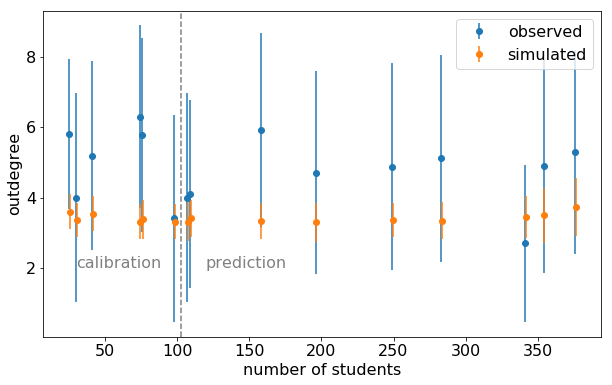

Mean student and between student standard deviation of the outdegree. Social networks show a bounded degree distribution, the degree distribution is more bounded in the simulation in comparison to the data


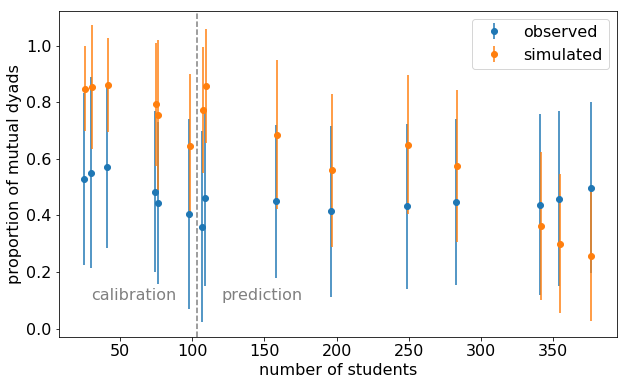

Mean student and between student standard deviation of the proportion of mutual dyads


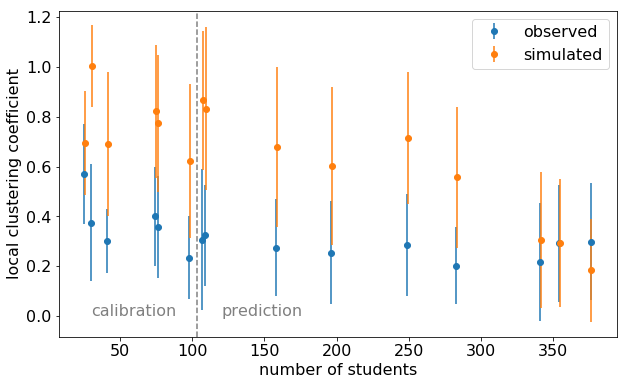

Mean student and between student standard deviation of the local clustering coefficient. Social networks show non-trivial clustering / locally dense clusters / triadic closure: direct neighbours are likely to also directly conect to eachother. The local clustering seems too high in our model compared to school data


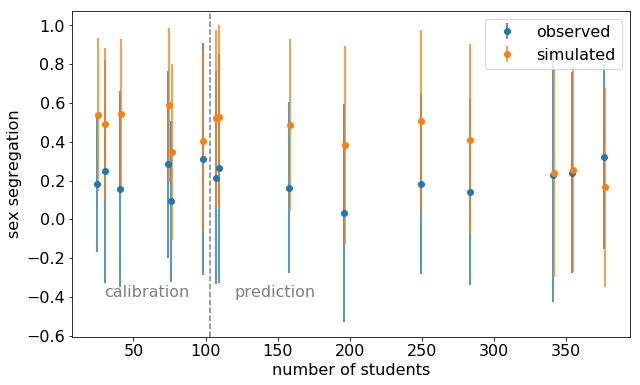

Mean student and between student standard deviation of the sex segregation


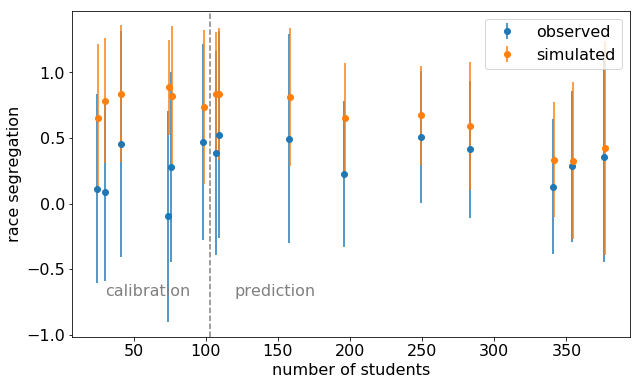

Mean student and between student standard deviation of the proportion of the race segregation


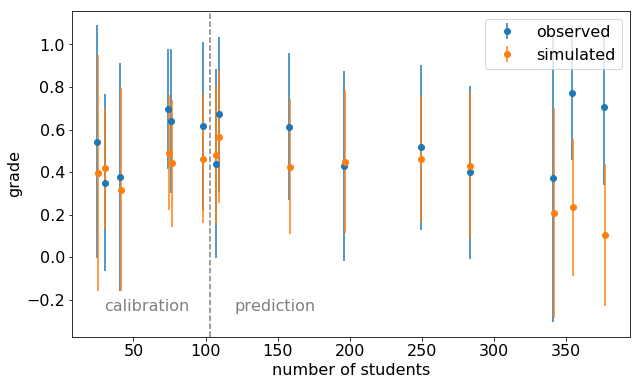

Mean student and between student standard deviation of the proportion of the grade segregation


In [43]:
# increase the font size
plt.rcParams.update({'font.size': 16})

plot_n_students_vs_characteristic('degree','degree_std','outdegree',2)
print("Mean student and between student standard deviation of the outdegree. Social networks show a bounded degree distribution, the degree distribution is more bounded in the simulation in comparison to the data")

plot_n_students_vs_characteristic('mut_prop','mut_prop_std','proportion of mutual dyads',0.1)
print("Mean student and between student standard deviation of the proportion of mutual dyads")

plot_n_students_vs_characteristic('cluster_coef','cluster_coef_std','local clustering coefficient',0)
print("Mean student and between student standard deviation of the local clustering coefficient. Social networks show non-trivial clustering / locally dense clusters / triadic closure: direct neighbours are likely to also directly conect to eachother. The local clustering seems too high in our model compared to school data")


plot_n_students_vs_characteristic('sex','sex_std','sex segregation',-0.4)
print("Mean student and between student standard deviation of the sex segregation")

plot_n_students_vs_characteristic('race','race_std','race segregation',-0.7)
print("Mean student and between student standard deviation of the proportion of the race segregation")

plot_n_students_vs_characteristic('grade','grade_std','grade',-0.25)
print("Mean student and between student standard deviation of the proportion of the grade segregation")